In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
# install tf 2.0
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf

print(tf.__version__)

    100% |████████████████████████████████| 332.1MB 67kB/s 
    100% |████████████████████████████████| 3.0MB 8.3MB/s 
    100% |████████████████████████████████| 61kB 24.2MB/s 
    100% |████████████████████████████████| 419kB 12.4MB/s 
2.0.0-alpha0


In [0]:
import os
from glob import glob

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

SEED = 42


def _float_list_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


def _int64_list_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def create_generator_for_ffn(
        file_list,
        mode='train'):

    # file_list = glob(os.path.join(data_dir, '*.csv'))

    for full_file_path in file_list:
        # full_file_path = os.path.join(data_dir, file_name)
        if not os.path.exists(full_file_path):
            raise FileNotFoundError("File %s not found" % full_file_path)
        df = pd.read_csv(full_file_path, encoding='utf8')

        # so train test split
        if mode == 'train':
            df, _ = train_test_split(df, test_size=0.2, random_state=SEED)
        else:
            _, df = train_test_split(df, test_size=0.2, random_state=SEED)

        for _, row in df.iterrows():
            q_vectors = np.fromstring(row.question_bert.replace(
                '[[', '').replace(']]', ''), sep=' ')
            a_vectors = np.fromstring(row.answer_bert.replace(
                '[[', '').replace(']]', ''), sep=' ')
            vectors = np.stack([q_vectors, a_vectors], axis=0)
            if mode in ['train', 'eval']:
                yield vectors, 1
            else:
                yield vectors


def ffn_serialize_fn(features):
    features_tuple = {'features': _float_list_feature(
        features[0].flatten()), 'labels': _int64_feature(features[1])}
    example_proto = tf.train.Example(
        features=tf.train.Features(feature=features_tuple))
    return example_proto.SerializeToString()


def make_tfrecord(data_dir, generator_fn, serialize_fn, suffix='', **kwargs):
    """Function to make TF Records from csv files
    This function will take all csv files in data_dir, convert them
    to tf example and write to *_{suffix}_train/eval.tfrecord to data_dir.

    Arguments:
        data_dir {str} -- dir that has csv files and store tf record
        generator_fn {fn} -- A function that takes a list of filepath and yield the
        parsed recored from file.
        serialize_fn {fn} -- A function that takes output of generator fn and convert to tf example

    Keyword Arguments:
        suffix {str} -- suffix to add to tf record files (default: {''})
    """
    file_list = glob(os.path.join(data_dir, '*.csv'))
    train_tf_record_file_list = [
        f.replace('.csv', '_{0}_train.tfrecord'.format(suffix)) for f in file_list]
    test_tf_record_file_list = [
        f.replace('.csv', '_{0}_eval.tfrecord'.format(suffix)) for f in file_list]
    for full_file_path, train_tf_record_file_path, test_tf_record_file_path in zip(file_list, train_tf_record_file_list, test_tf_record_file_list):
        print('Converting file {0} to TF Record'.format(full_file_path))
        with tf.io.TFRecordWriter(train_tf_record_file_path) as writer:
            for features in generator_fn([full_file_path], mode='train', **kwargs):
                example = serialize_fn(features)
                writer.write(example)
        with tf.io.TFRecordWriter(test_tf_record_file_path) as writer:
            for features in generator_fn([full_file_path], mode='eval', **kwargs):
                example = serialize_fn(features)
                writer.write(example)


def create_dataset_for_ffn(
        data_dir,
        mode='train',
        hidden_size=768,
        shuffle_buffer=10000,
        prefetch=10000,
        batch_size=32):

    tfrecord_file_list = glob(os.path.join(
        data_dir, '*_FFN_{0}.tfrecord'.format((mode))))
    if not tfrecord_file_list:
        print('TF Record not found')
        make_tfrecord(
            data_dir, create_generator_for_ffn,
            ffn_serialize_fn, 'FFN')

    dataset = tf.data.TFRecordDataset(tfrecord_file_list)

    def _parse_ffn_example(example_proto):
        feature_description = {
            'features': tf.io.FixedLenFeature([2*768], tf.float32),
            'labels': tf.io.FixedLenFeature([], tf.int64, default_value=0),
        }
        feature_dict = tf.io.parse_single_example(
            example_proto, feature_description)
        return tf.reshape(feature_dict['features'], (2, 768)), feature_dict['labels']
    dataset = dataset.map(_parse_ffn_example)

    dataset = dataset.shuffle(shuffle_buffer)

    dataset = dataset.prefetch(prefetch)

    dataset = dataset.batch(batch_size)
    return dataset

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

import tensorflow as tf
import tensorflow.keras.backend as K


class FFN(tf.keras.layers.Layer):
    def __init__(
            self,
            hidden_size=768,                                                                #SG edit from 768 4-24-19
            dropout=0.2,
            residual=True,
            name='FFN',
            **kwargs):
        """Simple Dense wrapped with various layers
        """

        super(FFN, self).__init__(name=name, **kwargs)
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.residual = residual
        self.ffn_layer = tf.keras.layers.Dense(
            units=hidden_size,
            use_bias=True
        )

    def call(self, inputs):
        ffn_embedding = self.ffn_layer(inputs)
        ffn_embedding = tf.keras.layers.ReLU()(ffn_embedding)
        if self.dropout > 0:
            ffn_embedding = tf.keras.layers.Dropout(
                self.dropout)(ffn_embedding)
#         ffn_embedding = self.ffn_layer(inputs)  #SG edit from 768 4-24-19
#         ffn_embedding = tf.keras.layers.ReLU()(ffn_embedding)  #SG edit from 768 4-24-19
#         if self.dropout > 0:  #SG edit from 768 4-24-19
#             ffn_embedding = tf.keras.layers.Dropout(  #SG edit from 768 4-24-19
#                 self.dropout)(ffn_embedding)  #SG edit from 768 4-24-19


        if self.residual:
            ffn_embedding += inputs
        return ffn_embedding


class MedicalQAModel(tf.keras.Model):
    def __init__(self, name=''):
        super(MedicalQAModel, self).__init__(name=name)
        self.q_ffn = FFN(name='QFFN', input_shape=(768,))
        self.a_ffn = FFN(name='AFFN', input_shape=(768,))

    def call(self, inputs):
        q_bert_embedding, a_bert_embedding = tf.unstack(inputs, axis=1)
        q_embedding, a_embedding = self.q_ffn(
            q_bert_embedding), self.a_ffn(a_bert_embedding)
        return tf.stack([q_embedding, a_embedding], axis=1)


class BioBert(tf.keras.Model):
    def __init__(self, name=''):
        super(BioBert, self).__init__(name=name)

    def call(self, inputs):

        # inputs is dict with input features
        input_ids, input_masks, segment_ids = inputs
        # pass to bert
        # with shape of (batch_size/2*batch_size, max_seq_len, hidden_size)
        # TODO(Alex): Add true bert model
        # Input: input_ids, input_masks, segment_ids all with shape (None, max_seq_len)
        # Output: a tensor with shape (None, max_seq_len, hidden_size)
        fake_bert_output = tf.expand_dims(tf.ones_like(
            input_ids, dtype=tf.float32), axis=-1)*tf.ones([1, 1, 768], dtype=tf.float32)
        max_seq_length = tf.shape(fake_bert_output)[-2]
        hidden_size = tf.shape(fake_bert_output)[-1]

        bert_output = tf.reshape(
            fake_bert_output, (-1, 2, max_seq_length, hidden_size))
        return bert_output


class MedicalQAModelwithBert(tf.keras.Model):
    def __init__(
            self,
            hidden_size=768,
            dropout=0.2,
            residual=True,
            activation=tf.keras.layers.ReLU(),
            name=''):
        super(MedicalQAModelwithBert, self).__init__(name=name)
        self.biobert = BioBert()
        self.q_ffn_layer = FFN(
            hidden_size=hidden_size,
            dropout=dropout,
            residual=residual,
            activation=activation)
        self.a_ffn_layer = FFN(
            hidden_size=hidden_size,
            dropout=dropout,
            residual=residual,
            activation=activation)

    def _avg_across_token(self, tensor):
        if tensor is not None:
            tensor = tf.reduce_mean(tensor, axis=1)
        return tensor

    def call(self, inputs):

        q_bert_embedding, a_bert_embedding = self.biobert(inputs)

        # according to USE, the DAN network average embedding across tokens
        q_bert_embedding = self._avg_across_token(q_bert_embedding)
        a_bert_embedding = self._avg_across_token(a_bert_embedding)

        q_embedding = self.q_ffn_layer(q_bert_embedding)
        a_embedding = self.a_ffn_layer(a_bert_embedding)

        return tf.stack([q_embedding, a_embedding], axis=1)

      
      
# def qa_pair_cross_entropy_loss(y_true, y_pred):
#     y_true = tf.eye(tf.shape(y_pred)[0])
#     q_embedding, a_embedding = tf.unstack(y_pred, axis=1)
#     similarity_matrix = tf.matmul(
#         q_embedding, a_embedding, transpose_b=True)
#     similarity_matrix_logits = tf.math.sigmoid(similarity_matrix)
#     return tf.keras.losses.categorical_crossentropy(y_true, similarity_matrix_logits, from_logits=True)

def qa_pair_cross_entropy_loss(y_true, y_pred):
    y_true = tf.eye(tf.shape(y_pred)[0])
    q_embedding, a_embedding = tf.unstack(y_pred, axis=1)
    similarity_matrix = tf.matmul(
        a = q_embedding, b = a_embedding, transpose_b=True)
    similarity_matrix_softmaxed = tf.nn.softmax(similarity_matrix)
    K.print_tensor(similarity_matrix_softmaxed, message="similarity_matrix_softmaxed is: ")
    return tf.keras.losses.categorical_crossentropy(y_true, similarity_matrix_softmaxed, from_logits=False)

#     y_true = tf.reshape(tf.eye(tf.shape(y_pred)[0])*2-1, (-1,))
#     q_embedding, a_embedding = tf.unstack(y_pred, axis=1)
#     similarity_matrix = tf.nn.softmax(tf.matmul(
#         q_embedding, a_embedding, transpose_b=True))
#     similarity_vector = tf.reshape(similarity_matrix, (-1, 1))
#     return tf.nn.softmax_cross_entropy_with_logits(similarity_vector, y_true)

#to try, with and without softmax
# catagorical cross entropy vs binary cross entropy
#with and without sigmoid pre transformation
#1 layer vs 2 layer 

#prioritize what he said. so softmax, then catagorical vs binary 


In [0]:
# training config
batch_size = 64
num_epochs=35
learning_rate=0.0001
validation_split=0.2
shuffle_buffer=50000
prefetch=50000
data_path='/content/gdrive/My Drive/mqa_tf_record'
model_path = '/content/gdrive/My Drive/mqa_models/ffn_model_cross_entropy'

In [58]:
  d = create_dataset_for_ffn(
      data_path, batch_size=batch_size, shuffle_buffer=shuffle_buffer, prefetch=prefetch)
  eval_d = create_dataset_for_ffn(
      data_path, batch_size=batch_size, mode='eval')
  medical_qa_model = MedicalQAModel()
  optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
  medical_qa_model.compile(
      optimizer=optimizer, loss=qa_pair_cross_entropy_loss)

  epochs = num_epochs
  loss_metric = tf.keras.metrics.Mean()

  history = medical_qa_model.fit(d, epochs=epochs, validation_data=eval_d)


Epoch 1/35
3349/3349 [==============================] - 112s 34ms/step - loss: 8.0786 - val_loss: 0.0000e+00
Epoch 2/35
3349/3349 [==============================] - 98s 29ms/step - loss: 5.1430 - val_loss: 4.0929
Epoch 3/35
3349/3349 [==============================] - 100s 30ms/step - loss: 4.5094 - val_loss: 4.0164
Epoch 4/35
3349/3349 [==============================] - 98s 29ms/step - loss: 4.1240 - val_loss: 3.7529
Epoch 5/35
3349/3349 [==============================] - 97s 29ms/step - loss: 3.8768 - val_loss: 3.8079
Epoch 6/35
3349/3349 [==============================] - 98s 29ms/step - loss: 3.6785 - val_loss: 3.5953
Epoch 7/35
3349/3349 [==============================] - 97s 29ms/step - loss: 3.5199 - val_loss: 3.4747
Epoch 8/35
3349/3349 [==============================] - 98s 29ms/step - loss: 3.3815 - val_loss: 3.4318
Epoch 9/35
3349/3349 [==============================] - 98s 29ms/step - loss: 3.2739 - val_loss: 3.3712
Epoch 10/35
3349/3349 [==============================] - 9

In [0]:
30, 31, 26, 12

In [50]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


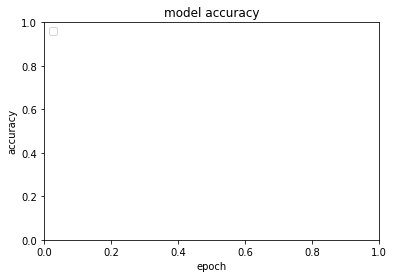

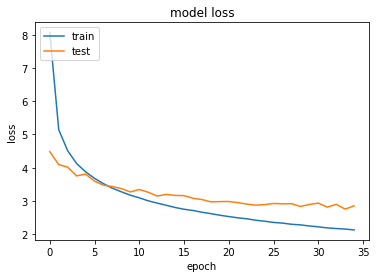

In [61]:
import matplotlib.pyplot as plt
# summarize history for accuracy
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
medical_qa_model.save_weights(model_path)

In [0]:
model_path2 = '/content/gdrive/My Drive/mqa_models/ffn_model_cross_entropy.ckpt'

checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path2, monitor='loss', verbose=1, save_best_only=True, mode='min')

In [0]:
history = medical_qa_model.fit(d, epochs=20, validation_data=eval_d, callbacks=[checkpoint])

Epoch 1/20
   3349/Unknown - 88s 26ms/step - loss: 2.0000
Epoch 00001: loss improved from inf to 1.99994, saving model to /content/gdrive/My Drive/mqa_models/ffn_model_cross_entropy.ckpt
3349/3349 [==============================] - 97s 29ms/step - loss: 2.0000 - val_loss: 0.0000e+00
Epoch 2/20
3346/3349 [============================>.] - ETA: 0s - loss: 1.9841
Epoch 00002: loss improved from 1.99994 to 1.98461, saving model to /content/gdrive/My Drive/mqa_models/ffn_model_cross_entropy.ckpt
3349/3349 [==============================] - 85s 25ms/step - loss: 1.9846 - val_loss: 2.7002
Epoch 3/20
3347/3349 [============================>.] - ETA: 0s - loss: 1.9696
Epoch 00003: loss improved from 1.98461 to 1.96986, saving model to /content/gdrive/My Drive/mqa_models/ffn_model_cross_entropy.ckpt
3349/3349 [==============================] - 86s 26ms/step - loss: 1.9698 - val_loss: 2.6948
Epoch 4/20
3347/3349 [============================>.] - ETA: 0s - loss: 1.9521
Epoch 00004: loss improved 

In [65]:
medical_qa_model2 = tf.keras.models.load_model(model_path)
checkpoint = ModelCheckpoint(model_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
history = medical_qa_model2.fit(d, epochs=epochs, validation_data=eval_d, callbacks=callbacks_list)



OSError: ignored